In [1]:
import requests
import pandas as pd
from datetime import datetime
import os
import gzip
import shutil
import pandas as pd
from sklearn.impute import KNNImputer
from datetime import datetime
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, trim
import requests
import pandas as pd
from datetime import datetime
from pyspark.sql.functions import col, count, when, isnan
from datetime import timedelta
from pyspark.sql import Window
from pyspark.sql.functions import last

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

    Importing Libraries: The code starts by importing necessary libraries:
        requests for making HTTP requests to the FMP API.
        pandas for data manipulation and analysis.
        datetime for handling dates and times.

    API Key and Stock Symbol:
        An API key for FMP is defined. This key is essential for authentication and accessing the data from FMP.
        The stock symbol ^STOXX50E for the EURO STOXX 50 index is specified.

    Building the API Request URL:
        The URL for the FMP API is constructed using string formatting. It includes the stock symbol, a date range (from February 1, 2005, to the current date), and the API key.

    Making the API Request:
        A GET request is made to the constructed URL using the requests library.
        The response is checked for a successful status code (200). If the request is successful, the data is processed; if not, an error message is displayed.

    Data Processing:
        The successful response is converted from JSON format to a Python dictionary.
        The code checks for the presence of the 'historical' key in the data, which contains the required historical stock price data.
        This historical data is then converted into a pandas DataFrame for easier manipulation and analysis.

    Filtering and Displaying Data:
        The DataFrame is filtered to include only the 'date' and 'close' columns, representing the closing prices of the stock on each date.
        Finally, the filtered DataFrame is displayed.

In [3]:
import requests
import pandas as pd
from datetime import datetime

# FMP API key
api_key = '47461a32a9bcf3b0a6c2c6e98ccfab42'

# Symbol for EURO STOXX 50
stock_symbol = '^STOXX50E'

# URL for the FMP historical data endpoint
url = f'https://financialmodelingprep.com/api/v3/historical-price-full/{stock_symbol}?from=2004-02-01&to={datetime.now().strftime("%Y-%m-%d")}&apikey={api_key}'

# FMP API request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Extract the historical data
    if 'historical' in data:
        historical_data = data['historical']

        # Convert to a pandas DataFrame
        index_df = pd.DataFrame(historical_data)

        # Filter the DataFrame to only include the 'Close' column
        index_df = index_df[['date', 'close']]

        # Display the DataFrame
        print(index_df)
    else:
        print("No 'historical' data found in the response.")
else:
    print(f'Failed to retrieve data: {response.status_code}')

            date        close
0     2024-01-26  4635.470220
1     2024-01-25  4582.259770
2     2024-01-24  4564.109860
3     2024-01-23  4465.910160
4     2024-01-22  4480.319820
...          ...          ...
1016  2020-02-07  3798.489990
1017  2020-02-06  3805.520020
1018  2020-02-05  3777.840088
1019  2020-02-04  3732.280029
1020  2020-02-03  3661.270020

[1021 rows x 2 columns]


## Technical Indicators

In [4]:
# FMP API key
api_key = '47461a32a9bcf3b0a6c2c6e98ccfab42'

# Symbol for EURO STOXX 50
stock_symbol = '^STOXX50E'

# URL for the FMP SMA technical indicator endpoint with daily data
sma_period = 50
url = f'https://financialmodelingprep.com/api/v3/technical_indicator/daily/{stock_symbol}?period={sma_period}&type=sma&apikey={api_key}'

# FMP API request for SMA data
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    sma_data = response.json()

    # Convert to a pandas DataFrame
    sma_df = pd.DataFrame(sma_data)

    # Ensure 'date' column is in datetime format
    sma_df['date'] = pd.to_datetime(sma_df['date'])

    # Format the 'date' column to display dates only
    sma_df['date'] = sma_df['date'].dt.strftime('%Y-%m-%d')

    # Filter the DataFrame for rows where the date is after February 1, 2005
    sma_df = sma_df[sma_df['date'] >= '2004-02-01']

    # Keep only the 'date' and 'sma' columns
    sma_df = sma_df[['date', 'sma']]

    # Display the DataFrame
    print(sma_df)
else:
    print(f'Failed to retrieve SMA data: {response.status_code}')

            date          sma
0     2024-01-26  4460.275762
1     2024-01-25  4453.400762
2     2024-01-24  4446.399365
3     2024-01-23  4439.064365
4     2024-01-22  4434.330166
...          ...          ...
1016  2020-02-07  3733.441206
1017  2020-02-06  3731.064604
1018  2020-02-05  3728.631802
1019  2020-02-04  3727.006201
1020  2020-02-03  3726.458999

[1021 rows x 2 columns]


In [5]:
# FMP API key
api_key = '47461a32a9bcf3b0a6c2c6e98ccfab42'

# Symbol for EURO STOXX 50
stock_symbol = '^STOXX50E'

# URL for the FMP EMA technical indicator endpoint with daily data
ema_period = 50
url = f'https://financialmodelingprep.com/api/v3/technical_indicator/daily/{stock_symbol}?period={ema_period}&type=ema&apikey={api_key}'

# FMP API request for EMA data
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    ema_data = response.json()

    # Convert to a pandas DataFrame
    ema_df = pd.DataFrame(ema_data)

    # Ensure 'date' column is in datetime format
    ema_df['date'] = pd.to_datetime(ema_df['date'])

    # Format the 'date' column to display dates only
    ema_df['date'] = ema_df['date'].dt.strftime('%Y-%m-%d')

    # Filter the DataFrame for rows where the date is after February 1, 2005
    ema_df = ema_df[ema_df['date'] >= '2004-02-01']

    # Keep only the 'date' and 'ema' columns
    ema_df = ema_df[['date', 'ema']]

    # Display the DataFrame
    print(ema_df)
else:
    print(f'Failed to retrieve EMA data: {response.status_code}')


            date          ema
0     2024-01-26  4440.930772
1     2024-01-25  4432.990386
2     2024-01-24  4426.897758
3     2024-01-23  4421.297264
4     2024-01-22  4419.476330
...          ...          ...
1016  2020-02-07  3724.103975
1017  2020-02-06  3721.067811
1018  2020-02-05  3717.620782
1019  2020-02-04  3715.162851
1020  2020-02-03  3714.464191

[1021 rows x 2 columns]


# Index + Technical Indicator 

In [6]:
# Merge index_df and sma_df on 'date'
merged_df = pd.merge(index_df, sma_df, on='date', how='left')

# Merge the result with ema_df on 'date'
index_data = pd.merge(merged_df, ema_df, on='date', how='left')

# Rename the columns appropriately
index_data.columns = ['Date', 'Close', 'SMA', 'EMA']

# Display the DataFrame
print(index_data)

            Date        Close          SMA          EMA
0     2024-01-26  4635.470220  4460.275762  4440.930772
1     2024-01-25  4582.259770  4453.400762  4432.990386
2     2024-01-24  4564.109860  4446.399365  4426.897758
3     2024-01-23  4465.910160  4439.064365  4421.297264
4     2024-01-22  4480.319820  4434.330166  4419.476330
...          ...          ...          ...          ...
1016  2020-02-07  3798.489990  3733.441206  3724.103975
1017  2020-02-06  3805.520020  3731.064604  3721.067811
1018  2020-02-05  3777.840088  3728.631802  3717.620782
1019  2020-02-04  3732.280029  3727.006201  3715.162851
1020  2020-02-03  3661.270020  3726.458999  3714.464191

[1021 rows x 4 columns]


## Removed SMA & EMA (API Problem Historic Data). Might back it when the API is ready again

In [7]:
index_data.describe()

,Close,SMA,EMA
count,1021.000000,1021.000000,1021.000000
mean,3844.347609,3826.418653,3826.967357
std,449.201569,413.782893,406.245891
min,2385.820068,2787.037207,2937.739941
25%,3517.250000,3556.154810,3530.651596
50%,3945.959961,3888.129805,3898.835821
75%,4209.150000,4197.753394,4195.106706
max,4635.470220,4460.275762,4440.930772


# Interest Rate API (Eurostat)

In [8]:
# Dataset code
dataset_code = "ei_mfir_m"

# API URL for downloading the dataset
api_url = f"https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/{dataset_code}?format=TSV&compressed=true"

# Download the dataset
response = requests.get(api_url, stream=True)
output_file = dataset_code + ".tsv.gz"

if response.status_code == 200:
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print(f"Error downloading dataset. Status code: {response.status_code}")

# Unzipping the dataset
with gzip.open(output_file, 'rb') as f_in:
    with open(dataset_code + ".tsv", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Dataset unzipped successfully.")

Dataset downloaded successfully.
Dataset unzipped successfully.


In [9]:
# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

# Construct the file path dynamically
file_name = 'ei_mfir_m.tsv'  # File Name
file_path = os.path.join(current_directory, file_name)

# Load the dataset
data = pd.read_csv(file_path, sep='\t')

# Split the first column into separate columns
split_columns = data.iloc[:, 0].str.split(',', expand=True)
split_columns.columns = ['freq', 's_adj', 'p_adj', 'indic', 'geo']

# Combine the split columns with the original data (excluding the first column)
structured_data = pd.concat([split_columns, data.iloc[:, 1:]], axis=1)

# Apply filters
structured_data = structured_data[
    (structured_data['indic'] == 'MF-3MI-RT')
]

# Drop unnecessary columns
structured_data.drop(['freq', 's_adj', 'p_adj'], axis=1, inplace=True)

# Filter for date range (from October 1, 2004, onwards)
date_columns = structured_data.columns[3:]
dates_from_oct_2004 = date_columns[date_columns >= '2004-02-01 ']
structured_data = structured_data[['indic','geo'] + list(dates_from_oct_2004)]

# Reset the index for a clean table
structured_data.reset_index(drop=True, inplace=True)

# Display the structured DataFrame
pd.set_option('display.max_columns', None)

Current Working Directory: /home/fabiopoli/Desktop


In [10]:
# Filter out only the columns with date values for melting
date_columns = structured_data.columns[5:]  
data_for_melting = structured_data[['geo'] + list(date_columns)]

# Melt the DataFrame to change its structure
structured_data = pd.melt(data_for_melting, id_vars=['geo'], var_name='Period', value_name='Interest')

# Filter for 'geo' == 'EA'
Interest_data_ea = structured_data[structured_data['geo'] == 'EA']

# Apply forward filling
Interest_data_ea.loc[:, 'Interest'] = Interest_data_ea['Interest'].ffill()

# Rearrange the columns
Interest_data_ea = Interest_data_ea[['Period', 'geo', 'Interest']]

# Display the transformed DataFrame
pd.set_option('display.max_rows', None)  # This option displays all the rows
print(Interest_data_ea.head(10))


       Period geo  Interest
3    2005-06   EA  2.11100 
16   2005-07   EA  2.11940 
29   2005-08   EA  2.13250 
42   2005-09   EA  2.13910 
55   2005-10   EA  2.19660 
68   2005-11   EA  2.36090 
81   2005-12   EA  2.47290 
94   2006-01   EA  2.51170 
107  2006-02   EA  2.60040 
120  2006-03   EA  2.72260 


In [11]:
# Convert 'Period' to datetime
Interest_data_ea['Period'] = pd.to_datetime(Interest_data_ea['Period'])

# Set 'Period' as the index
Interest_data_ea.set_index('Period', inplace=True)

# Create a daily date range that covers the entire period in your data
start_date = Interest_data_ea.index.min()
end_date = Interest_data_ea.index.max()
all_days = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex the DataFrame to this date range, forward filling the missing values
daily_interest_data = Interest_data_ea.reindex(all_days).ffill()

# Reset the index so 'Period' becomes a column again
daily_interest_data.reset_index(inplace=True)
daily_interest_data.rename(columns={'index': 'Period'}, inplace=True)

# Display the first 10 rows of the daily data
print(daily_interest_data.head(10))

      Period geo  Interest
0 2005-06-01  EA  2.11100 
1 2005-06-02  EA  2.11100 
2 2005-06-03  EA  2.11100 
3 2005-06-04  EA  2.11100 
4 2005-06-05  EA  2.11100 
5 2005-06-06  EA  2.11100 
6 2005-06-07  EA  2.11100 
7 2005-06-08  EA  2.11100 
8 2005-06-09  EA  2.11100 
9 2005-06-10  EA  2.11100 


In [12]:
# Check if 'Period' is in the columns; if not, the index might already be the 'Period'
if 'Period' in Interest_data_ea.columns:
    Interest_data_ea['Period'] = pd.to_datetime(Interest_data_ea['Period'])
    Interest_data_ea.set_index('Period', inplace=True)
elif not isinstance(Interest_data_ea.index, pd.DatetimeIndex):
    # If the index is not a datetime, convert it
    Interest_data_ea.index = pd.to_datetime(Interest_data_ea.index)

# Create a daily date range
start_date = Interest_data_ea.index.min()
end_date = Interest_data_ea.index.max()
all_days = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex to create a DataFrame with all days, introducing NaNs for days without data
interest_data = Interest_data_ea.reindex(all_days)

# Convert the index to a numerical value for KNN
interest_data['Day_Ordinal'] = interest_data.index.map(datetime.toordinal)

# Extract the 'Interest' column for imputation
knn_data = interest_data[['Day_Ordinal', 'Interest']].values

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation
knn_data_imputed = knn_imputer.fit_transform(knn_data)

# Put the imputed 'Interest' data back into the DataFrame
interest_data['Interest'] = knn_data_imputed[:, 1]

# Drop the 'Day_Ordinal' column as it's no longer needed
interest_data.drop('Day_Ordinal', axis=1, inplace=True)

# Reset index to make 'Period' a column again
interest_data.reset_index(inplace=True)
interest_data.rename(columns={'index': 'Period'}, inplace=True)

# If the 'geo' column is required, fill it with a constant value (e.g., 'EA')
interest_data['geo'] = 'EA'

# Display the first 10 rows of the daily data
print(interest_data.head(10))

      Period geo  Interest
0 2005-06-01  EA   2.11100
1 2005-06-02  EA   2.13972
2 2005-06-03  EA   2.13972
3 2005-06-04  EA   2.13972
4 2005-06-05  EA   2.13972
5 2005-06-06  EA   2.13972
6 2005-06-07  EA   2.13972
7 2005-06-08  EA   2.13972
8 2005-06-09  EA   2.13972
9 2005-06-10  EA   2.13972


# Bonds Yields API (Eurostat)

In [13]:
# Dataset code
dataset_code = "irt_euryld_d"

# API URL for downloading the dataset
api_url = f"https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/{dataset_code}?format=TSV&compressed=true"

# Download the dataset
response = requests.get(api_url, stream=True)
output_file = dataset_code + ".tsv.gz"

if response.status_code == 200:
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print(f"Error downloading dataset. Status code: {response.status_code}")

# Unzipping the dataset
with gzip.open(output_file, 'rb') as f_in:
    with open(dataset_code + ".tsv", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Dataset unzipped successfully.")

Dataset downloaded successfully.
Dataset unzipped successfully.


In [14]:
# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

# Construct the file path dynamically
file_name = 'irt_euryld_d.tsv'  # File Name
file_path = os.path.join(current_directory, file_name)

# Load the dataset
data = pd.read_csv(file_path, sep='\t')

# Split the first column into separate columns
split_columns = data.iloc[:, 0].str.split(',', expand=True)
split_columns.columns = ['freq', 'yld_curv', 'maturity', 'bonds', 'geo']

# Combine the split columns with the original data (excluding the first column)
structured_data = pd.concat([split_columns, data.iloc[:, 1:]], axis=1)

# Apply filters
structured_data = structured_data[
    (structured_data['yld_curv'] == 'SPOT_RT') & 
    (structured_data['bonds'] == 'CGB_EA')
]

# Drop unnecessary columns
structured_data.drop(['freq', 'geo'], axis=1, inplace=True)

# Filter for date range (from October 1, 2004, onwards)
date_columns = structured_data.columns[3:]
dates_from_oct_2004 = date_columns[date_columns >= '2004-10-01 ']
structured_data = structured_data[['yld_curv', 'maturity', 'bonds'] + list(dates_from_oct_2004)]

# Reset the index for a clean table
structured_data.reset_index(drop=True, inplace=True)

# Display the structured DataFrame
pd.set_option('display.max_columns', None)

Current Working Directory: /home/fabiopoli/Desktop


In [15]:
# Filter out only the columns with date values for melting
date_columns = structured_data.columns[3:]  # Assuming date columns start from the 4th column
data_for_melting = structured_data[['maturity'] + list(date_columns)]

# Melt the DataFrame to change its structure
bonds_data = pd.melt(data_for_melting, id_vars=['maturity'], var_name='Period', value_name='Rate')

# Specify the desired maturities (M1 to M12 and Y1 to Y30)
desired_maturities = [f'M{i}' for i in range(1, 3)] + [f'Y{i}' for i in range(1, 10)]

# Filter the DataFrame to include only the specified maturities
bonds_data = bonds_data[bonds_data['maturity'].isin(desired_maturities)]

# Rearrange the columns
bonds_data = bonds_data[['Period', 'maturity', 'Rate']]

# Display the transformed DataFrame
pd.set_option('display.max_rows', None)  # This option displays all the rows
print(bonds_data.head())


          Period maturity     Rate
9    2004-10-01        Y1  2.27378
141  2004-10-01        Y2  2.58136
273  2004-10-01        Y3  2.86602
286  2004-10-01        Y4  3.12325
298  2004-10-01        Y5  3.35223


# Inflation Rate API (Eurostat)

In [16]:
# Dataset code
dataset_code = "prc_hicp_manr"

# API URL for downloading the dataset
api_url = f"https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/{dataset_code}?format=TSV&compressed=true"

# Download the dataset
response = requests.get(api_url, stream=True)
output_file = dataset_code + ".tsv.gz"

if response.status_code == 200:
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print(f"Error downloading dataset. Status code: {response.status_code}")

# Unzipping the dataset
with gzip.open(output_file, 'rb') as f_in:
    with open(dataset_code + ".tsv", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Dataset unzipped successfully.")

Dataset downloaded successfully.
Dataset unzipped successfully.


In [17]:
# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

# Construct the file path dynamically
file_name = 'prc_hicp_manr.tsv'  # File Name
file_path = os.path.join(current_directory, file_name)

# Load the dataset
data = pd.read_csv(file_path, sep='\t')

# Split the first column into separate columns
split_columns = data.iloc[:, 0].str.split(',', expand=True)
split_columns.columns = ['freq', 'unit', 'coicop', 'geo']

# Combine the split columns with the original data (excluding the first column)
structured_data = pd.concat([split_columns, data.iloc[:, 1:]], axis=1)

# Apply filters
structured_data = structured_data[
    (structured_data['unit'] == 'RCH_A') & 
    (structured_data['coicop'] == 'CP00')
]

# Drop unnecessary columns
structured_data.drop(['freq'], axis=1, inplace=True)

# Filter for date range (from January 1, 2005, onwards)
date_columns = structured_data.columns[3:]
dates_from_oct_2004 = date_columns[date_columns >= '2004-02-01 ']
structured_data = structured_data[['unit', 'coicop', 'geo'] + list(dates_from_oct_2004)]

# Reset the index for a clean table
structured_data.reset_index(drop=True, inplace=True)

# Display the structured DataFrame
pd.set_option('display.max_columns', None)

Current Working Directory: /home/fabiopoli/Desktop


In [18]:
# Filter out only the columns with date values for melting
date_columns = structured_data.columns[5:]  # Assuming date columns start from the 6th column
data_for_melting = structured_data[['geo'] + list(date_columns)]

# Melt the DataFrame to change its structure
inflation_data = pd.melt(data_for_melting, id_vars=['geo'], var_name='Period', value_name='Inflation')

# Filter for 'geo' == 'EA'
inflation_data_ea = inflation_data[inflation_data['geo'] == 'EA']

# Apply forward filling
inflation_data_ea.loc[:, 'Inflation'] = inflation_data_ea['Inflation'].ffill()

# Rearrange the columns
inflation_data_ea = inflation_data_ea[['Period', 'geo', 'Inflation']]

# Display the transformed DataFrame
pd.set_option('display.max_rows', None)  # This option displays all the rows
print(inflation_data_ea.head(10))

       Period geo Inflation
9    2005-05   EA      2.0 
54   2005-06   EA      2.0 
99   2005-07   EA      2.1 
144  2005-08   EA      2.2 
189  2005-09   EA      2.6 
234  2005-10   EA      2.5 
279  2005-11   EA      2.3 
324  2005-12   EA      2.3 
369  2006-01   EA      2.4 
414  2006-02   EA      2.4 


In [19]:
# Convert 'Period' to datetime
inflation_data_ea['Period'] = pd.to_datetime(inflation_data_ea['Period'])

# Set 'Period' as the DataFrame index
inflation_data_ea.set_index('Period', inplace=True)

# Resample to daily data using forward fill
daily_data_ffill = inflation_data_ea.resample('D').ffill()

# Reset index to move 'Period' back to a column
daily_data_ffill.reset_index(inplace=True)

# Display the first 10 rows of the daily data
print(daily_data_ffill.head(10))

      Period geo Inflation
0 2005-05-01  EA      2.0 
1 2005-05-02  EA      2.0 
2 2005-05-03  EA      2.0 
3 2005-05-04  EA      2.0 
4 2005-05-05  EA      2.0 
5 2005-05-06  EA      2.0 
6 2005-05-07  EA      2.0 
7 2005-05-08  EA      2.0 
8 2005-05-09  EA      2.0 
9 2005-05-10  EA      2.0 


In [20]:
# Check if 'Period' is in the columns; if not, the index should already be the 'Period'
if 'Period' in inflation_data_ea.columns:
    inflation_data_ea['Period'] = pd.to_datetime(inflation_data_ea['Period'])
    inflation_data_ea.set_index('Period', inplace=True)
elif not isinstance(inflation_data_ea.index, pd.DatetimeIndex):
    # If the index is not a datetime, convert it
    inflation_data_ea.index = pd.to_datetime(inflation_data_ea.index)

# Convert non-numeric values to NaN in the 'Inflation' column
inflation_data_ea['Inflation'] = pd.to_numeric(inflation_data_ea['Inflation'], errors='coerce')

# Create a daily date range that covers the entire period of your data
date_range = pd.date_range(start=inflation_data_ea.index.min(), end=inflation_data_ea.index.max(), freq='D')

# Create a new DataFrame for KNN imputation
inflation_data = pd.DataFrame(date_range, columns=['Period'])

# Merge with your existing data - this will introduce NaNs for days without data
inflation_data = inflation_data.merge(inflation_data_ea, how='left', left_on='Period', right_index=True)

# Convert 'Period' to a numerical value (e.g., days since start)
min_date = inflation_data['Period'].min()
inflation_data['Day_Ordinal'] = (inflation_data['Period'] - min_date).dt.days

# Prepare data for KNN imputation
knn_data = inflation_data[['Day_Ordinal', 'Inflation']]

# Initialize KNN Imputer - 5 neighbors / Week
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation
knn_data_imputed = knn_imputer.fit_transform(knn_data)

# Add imputed data back to DataFrame
inflation_data['Inflation'] = knn_data_imputed[:, 1]

# Fill 'geo' column with 'EA'
inflation_data['geo'] = 'EA'

# Convert 'Day_Ordinal' back to datetime
inflation_data['Period'] = inflation_data['Day_Ordinal'].apply(lambda x: min_date + timedelta(days=x))

# Drop the 'Day_Ordinal' column
inflation_data.drop(columns='Day_Ordinal', inplace=True)

# Display the first 10 rows of the daily data
print(inflation_data.head(10))

      Period geo  Inflation
0 2005-05-01  EA       2.00
1 2005-05-02  EA       2.18
2 2005-05-03  EA       2.18
3 2005-05-04  EA       2.18
4 2005-05-05  EA       2.18
5 2005-05-06  EA       2.18
6 2005-05-07  EA       2.18
7 2005-05-08  EA       2.18
8 2005-05-09  EA       2.18
9 2005-05-10  EA       2.18


# SparkSQL: Tables Connection

In [21]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("Stock Market Trends Analysis") \
    .getOrCreate()

# Function to format date columns in Pandas DataFrame
def format_date_columns(df, date_column):
    df[date_column] = pd.to_datetime(df[date_column]).dt.date
    return df

# Format date columns
index_data = format_date_columns(index_data, 'Date')
interest_data = format_date_columns(interest_data, 'Period')
bonds_data = format_date_columns(bonds_data, 'Period')
inflation_data = format_date_columns(inflation_data, 'Period')

# Convert the Pandas DataFrames to Spark DataFrames
index_df = spark.createDataFrame(index_data)
interest_df = spark.createDataFrame(interest_data)
bonds_df = spark.createDataFrame(bonds_data)
inflation_df = spark.createDataFrame(inflation_data)

# Trim and convert date columns to DateType
index_df = index_df.withColumn("date", to_date(trim(col("date")), "yyyy-MM-dd"))
interest_df = interest_df.withColumn("Period", to_date(trim(col("Period")), "yyyy-MM-dd"))
bonds_df = bonds_df.withColumn("Period", to_date(trim(col("Period")), "yyyy-MM-dd"))
inflation_df = inflation_df.withColumn("Period", to_date(trim(col("Period")), "yyyy-MM-dd"))

# Create Temporary Views
index_df.createOrReplaceTempView("indexView")
interest_df.createOrReplaceTempView("interestView")
bonds_df.createOrReplaceTempView("bondsView")
inflation_df.createOrReplaceTempView("inflationView")

# SQL Query for Joining
join_query = """
SELECT i.Date, i.Close, i.SMA, i.EMA,
       int.Interest as InterestRate, 
       b.Rate as BondRate, b.maturity as BondMaturity, 
       inf.Inflation as InflationRate
FROM indexView i
LEFT JOIN interestView int ON i.date = int.Period
LEFT JOIN bondsView b ON i.date = b.Period
LEFT JOIN inflationView inf ON i.date = inf.Period
"""

# Execute the query
dataset = spark.sql(join_query)

# Show the result
dataset.show(10)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/28 10:15:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/28 10:15:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+----------+----------+-----------------+-----------------+------------+--------+------------+-------------+
|      Date|     Close|              SMA|              EMA|InterestRate|BondRate|BondMaturity|InflationRate|
+----------+----------+-----------------+-----------------+------------+--------+------------+-------------+
|2024-01-18| 4453.0498|4422.384375199999|4415.693446301613|        NULL| 2.97949|          Y9|         NULL|
|2024-01-18| 4453.0498|4422.384375199999|4415.693446301613|        NULL| 2.91163|          Y8|         NULL|
|2024-01-18| 4453.0498|4422.384375199999|4415.693446301613|        NULL| 2.83952|          Y7|         NULL|
|2024-01-18| 4453.0498|4422.384375199999|4415.693446301613|        NULL| 2.76695|          Y6|         NULL|
|2024-01-18| 4453.0498|4422.384375199999|4415.693446301613|        NULL| 2.70241|          Y5|         NULL|
|2024-01-18| 4453.0498|4422.384375199999|4415.693446301613|        NULL| 2.66365|          Y4|         NULL|
|2024-01-18| 4453.0

In [22]:
# DataFrame: joined_df
numeric_column_types = ['int', 'double', 'float', 'long']

# Counting zeros and nulls for each column
for column in dataset.columns:
    # Check if the column is numeric
    if str(dataset.schema[column].dataType) in numeric_column_types:
        zero_count = dataset.filter(col(column) == 0).count()
        null_or_nan_count = joined_df.filter(col(column).isNull() | isnan(col(column))).count()
    else:
        zero_count = 'N/A' # Not applicable for non-numeric columns
        null_or_nan_count = dataset.filter(col(column).isNull()).count() # Check only for nulls in non-numeric columns

    print(f"Column '{column}': Zeros = {zero_count}, Nulls or NaNs = {null_or_nan_count}")

Column 'Date': Zeros = N/A, Nulls or NaNs = 0
Column 'Close': Zeros = N/A, Nulls or NaNs = 0
Column 'SMA': Zeros = N/A, Nulls or NaNs = 0
Column 'EMA': Zeros = N/A, Nulls or NaNs = 0
Column 'InterestRate': Zeros = N/A, Nulls or NaNs = 301
Column 'BondRate': Zeros = N/A, Nulls or NaNs = 16


Column 'BondMaturity': Zeros = N/A, Nulls or NaNs = 16
Column 'InflationRate': Zeros = N/A, Nulls or NaNs = 301


In [23]:
# Print the schema of the DataFrame
dataset.printSchema()

# Count the number of rows in the DataFrame
print("Number of rows:", dataset.count())

# Show statistical summaries of the DataFrame
dataset.describe().show()

root
 |-- Date: date (nullable = true)
 |-- Close: double (nullable = true)
 |-- SMA: double (nullable = true)
 |-- EMA: double (nullable = true)
 |-- InterestRate: double (nullable = true)
 |-- BondRate: string (nullable = true)
 |-- BondMaturity: string (nullable = true)
 |-- InflationRate: double (nullable = true)

Number of rows: 9061


24/01/28 10:15:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------------------+------------------+------------------+------------+------------------+
|summary|            Close|               SMA|               EMA|      InterestRate|          BondRate|BondMaturity|     InflationRate|
+-------+-----------------+------------------+------------------+------------------+------------------+------------+------------------+
|  count|             9061|              9061|              9061|              8760|              9045|        9045|              8760|
|   mean|3842.164593128353|3824.9077911961144| 3825.310561358991|0.7120496689497737| 1.020634161415144|        NULL| 4.310000000000015|
| stddev|448.2272441931736| 413.2100391503772|405.70934761901736|1.6818669023910848|1.5202415030290586|        NULL|3.3349256584162217|
|    min|     2385.8200684|2787.0372070380004|2937.7399410424273|            -0.582|          -0.00122|          Y1|              -0.3|
|    max|       4635.47022|      4460.2757622| 4

In [24]:
# Count the total number of rows
total_rows = dataset.count()

# Count rows where specific columns are available but others are missing (Null or NaN)
# Adjust column names as per your DataFrame
missing_columns_count = dataset.filter(
    (col("InterestRate").isNull() | isnan(col("InterestRate"))) &
    (col("BondRate").isNull() | isnan(col("BondRate"))) &
    (col("InflationRate").isNull() | isnan(col("InflationRate"))) &
    col("Close").isNotNull()
).count()

# Calculate the percentage of such instances
percentage_missing_columns = (missing_columns_count / total_rows) * 100

print(f"Total Rows: {total_rows}")
print(f"Rows with 'Open' but missing 'InterestRate', 'BondRate', and 'InflationRate': {missing_columns_count}")
print(f"Percentage of Rows with missing rates: {percentage_missing_columns:.2f}%")

# Filter the DataFrame to get rows with missing 'InterestRate', 'BondRate', and 'InflationRate' but available 'Open'
missing_values_table = dataset.filter(
    (col("InterestRate").isNull() | isnan(col("InterestRate"))) &
    (col("BondRate").isNull() | isnan(col("BondRate"))) &
    (col("InflationRate").isNull() | isnan(col("InflationRate"))) &
    col("Close").isNotNull()
)

# Show the rows with missing values
missing_values_table.show()


Total Rows: 9061
Rows with 'Open' but missing 'InterestRate', 'BondRate', and 'InflationRate': 4
Percentage of Rows with missing rates: 0.04%
+----------+----------+-----------------+-----------------+------------+--------+------------+-------------+
|      Date|     Close|              SMA|              EMA|InterestRate|BondRate|BondMaturity|InflationRate|
+----------+----------+-----------------+-----------------+------------+--------+------------+-------------+
|2023-12-29| 4521.6499|4323.256606600001|4386.024278247527|        NULL|    NULL|        NULL|         NULL|
|2024-01-26|4635.47022|     4460.2757622|4440.930771895976|        NULL|    NULL|        NULL|         NULL|
|2023-12-22|4521.47021|4300.129204200001|4368.764145296709|        NULL|    NULL|        NULL|         NULL|
|2024-01-25|4582.25977|      4453.400762|4432.990386259077|        NULL|    NULL|        NULL|         NULL|
+----------+----------+-----------------+-----------------+------------+--------+------------+-

In [25]:
# Count the total number of rows
total_rows = dataset.count()

# Count rows where any one of the specific columns is available but others are missing (Null or NaN)
# Adjust column names as per your DataFrame
missing_any_column_count = dataset.filter(
    col("Close").isNotNull() &
    (
        col("InterestRate").isNull() | isnan(col("InterestRate")) |
        col("BondRate").isNull() | isnan(col("BondRate")) |
        col("InflationRate").isNull() | isnan(col("InflationRate"))
    )
).count()

# Calculate the percentage of such instances
percentage_missing_any_column = (missing_any_column_count / total_rows) * 100

print(f"Total Rows: {total_rows}")
print(f"Rows with 'Open' but missing any one of 'InterestRate', 'BondRate', or 'InflationRate': {missing_any_column_count}")
print(f"Percentage of Rows with missing any one rate: {percentage_missing_any_column:.2f}%")

# Filter the DataFrame to get rows with missing any one of 'InterestRate', 'BondRate', and 'InflationRate' but available 'Open'
missing_any_values_table = dataset.filter(
    col("Close").isNotNull() &
    (
        col("InterestRate").isNull() | isnan(col("InterestRate")) |
        col("BondRate").isNull() | isnan(col("BondRate")) |
        col("InflationRate").isNull() | isnan(col("InflationRate"))
    )
)

# Show the rows with missing values
missing_any_values_table.show()


Total Rows: 9061
Rows with 'Open' but missing any one of 'InterestRate', 'BondRate', or 'InflationRate': 313
Percentage of Rows with missing any one rate: 3.45%
+----------+----------+-----------------+-----------------+------------+--------+------------+-------------+
|      Date|     Close|              SMA|              EMA|InterestRate|BondRate|BondMaturity|InflationRate|
+----------+----------+-----------------+-----------------+------------+--------+------------+-------------+
|2024-01-11|4442.27979|4390.752783400001|4408.840174955641|        NULL| 2.86198|          Y9|         NULL|
|2024-01-11|4442.27979|4390.752783400001|4408.840174955641|        NULL| 2.79284|          Y8|         NULL|
|2024-01-11|4442.27979|4390.752783400001|4408.840174955641|        NULL| 2.72034|          Y7|         NULL|
|2024-01-11|4442.27979|4390.752783400001|4408.840174955641|        NULL| 2.64911|          Y6|         NULL|
|2024-01-11|4442.27979|4390.752783400001|4408.840174955641|        NULL| 2.5

## Window Approuch

In [26]:
from pyspark.sql import Window
from pyspark.sql.functions import last

# Define the window specification for forward fill with partitioning by 'date'
window_spec = Window.partitionBy("Date").orderBy("Date").rowsBetween(Window.unboundedPreceding, Window.currentRow)

# Apply forward fill for each column that needs imputation
dataset_ff = dataset.withColumn("InterestRate", last("InterestRate", ignorenulls=True).over(window_spec)) \
                    .withColumn("BondRate", last("BondRate", ignorenulls=True).over(window_spec)) \
                    .withColumn("InflationRate", last("InflationRate", ignorenulls=True).over(window_spec))

# Show the result
dataset_ff.show()

+----------+------------+-----------------+------------------+------------+--------+------------+------------------+
|      Date|       Close|              SMA|               EMA|InterestRate|BondRate|BondMaturity|     InflationRate|
+----------+------------+-----------------+------------------+------------+--------+------------+------------------+
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|    -0.37308|-0.07879|          Y9|0.9799999999999999|
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|    -0.37308|-0.14737|          Y8|0.9799999999999999|
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|    -0.37308|-0.21287|          Y7|0.9799999999999999|
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|    -0.37308|-0.27418|          Y6|0.9799999999999999|
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|    -0.37308|-0.33024|          Y5|0.9799999999999999|
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|  

In [27]:
from pyspark.sql.functions import col, isnan, count

# Count the total number of rows
total_rows = dataset_ff.count()

# Count rows where 'Open' is available but any one of 'InterestRate', 'BondRate', or 'InflationRate' is missing (Null or NaN)
missing_any_column_count = dataset_ff.filter(
    col("Close").isNotNull() &
    (
        col("InterestRate").isNull() | isnan(col("InterestRate")) |
        col("BondRate").isNull() | isnan(col("BondRate")) |
        col("InflationRate").isNull() | isnan(col("InflationRate"))
    )
).count()

# Calculate the percentage of such instances
percentage_missing_any_column = (missing_any_column_count / total_rows) * 100

# Output the results
print(f"Total Rows: {total_rows}")
print(f"Rows with 'Open' but missing any one of 'InterestRate', 'BondRate', or 'InflationRate': {missing_any_column_count}")
print(f"Percentage of Rows with missing any one rate: {percentage_missing_any_column:.2f}%")

Total Rows: 9061
Rows with 'Open' but missing any one of 'InterestRate', 'BondRate', or 'InflationRate': 313
Percentage of Rows with missing any one rate: 3.45%


Here's why the Window function is used:

    Row-wise Calculations: PySpark's Window function allows you to specify a range of rows (a window) relative to the current row and perform calculations across these rows.

    Emulating ffill: By ordering the rows in the window based on the 'date' column and then using the last function (which returns the last non-null value in the window), we effectively emulate the forward fill behavior. It picks the last non-null value encountered in the ordered window and applies it to the current row if the current value is null.

    Scalability and Performance: PySpark is designed for big data processing. While Pandas' ffill is straightforward and efficient for in-memory data on a single machine, PySpark's window functions are designed to work efficiently on distributed datasets across multiple nodes in a cluster.

    Lack of Direct ffill Equivalent: PySpark DataFrame API does not have a direct method like ffill in Pandas. Therefore, the combination of Window and last functions is a common approach to achieve similar functionality.

### Because of the Nature of the Fields (Interest Rate and Inflation Rate), is possible to use the MEAN to fill the Missing Day Value

In [28]:
from pyspark.sql.functions import mean

# Define the numeric columns
numeric_cols = ["InterestRate", "BondRate", "InflationRate"]

# Calculate the mean of non-null values for each column
mean_values = dataset_ff.select([mean(c).alias(c) for c in numeric_cols]).collect()[0].asDict()

# Fill null values with the mean
for col in numeric_cols:
    dataset_ff = dataset_ff.na.fill({col: mean_values[col]})

# Show the result
dataset_ff.show()

+----------+------------+-----------------+------------------+------------+--------+------------+------------------+
|      Date|       Close|              SMA|               EMA|InterestRate|BondRate|BondMaturity|     InflationRate|
+----------+------------+-----------------+------------------+------------+--------+------------+------------------+
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|    -0.37308|-0.07879|          Y9|0.9799999999999999|
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|    -0.37308|-0.14737|          Y8|0.9799999999999999|
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|    -0.37308|-0.21287|          Y7|0.9799999999999999|
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|    -0.37308|-0.27418|          Y6|0.9799999999999999|
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|    -0.37308|-0.33024|          Y5|0.9799999999999999|
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|  

In [29]:
from pyspark.sql.functions import col, isnan, count

# Count the total number of rows
total_rows = dataset_ff.count()

# Count rows where 'Open' is available but any one of 'InterestRate', 'BondRate', or 'InflationRate' is missing (Null or NaN)
missing_any_column_count = dataset_ff.filter(
    col("Close").isNotNull() &
    (
        col("InterestRate").isNull() | isnan(col("InterestRate")) |
        col("BondRate").isNull() | isnan(col("BondRate")) |
        col("InflationRate").isNull() | isnan(col("InflationRate"))
    )
).count()

# Calculate the percentage of such instances
percentage_missing_any_column = (missing_any_column_count / total_rows) * 100

# Output the results
print(f"Total Rows: {total_rows}")
print(f"Rows with 'Open' but missing any one of 'InterestRate', 'BondRate', or 'InflationRate': {missing_any_column_count}")
print(f"Percentage of Rows with missing any one rate: {percentage_missing_any_column:.2f}%")

Total Rows: 9061
Rows with 'Open' but missing any one of 'InterestRate', 'BondRate', or 'InflationRate': 0
Percentage of Rows with missing any one rate: 0.00%


## KNN Approuch

In [30]:
# Convert Spark DataFrame to Pandas DataFrame
dataset_pd = dataset.toPandas()

# Replace non-numeric values to NaN
numeric_cols = ["InterestRate", "BondRate", "InflationRate"]
dataset_pd[numeric_cols] = dataset_pd[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
dataset_pd[numeric_cols] = knn_imputer.fit_transform(dataset_pd[numeric_cols])

# Convert back to Spark DataFrame
dataset_knn = spark.createDataFrame(dataset_pd)


In [31]:
# Sort the DataFrame in ascending order by the 'date' column
dataset_knn = dataset_knn.orderBy("Date")

# Show the result
dataset_knn.show()


+----------+------------+-----------------+------------------+------------+--------+------------+------------------+
|      Date|       Close|              SMA|               EMA|InterestRate|BondRate|BondMaturity|     InflationRate|
+----------+------------+-----------------+------------------+------------+--------+------------+------------------+
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|    -0.37308|-0.07879|          Y9|0.9799999999999999|
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|    -0.37308|-0.14737|          Y8|0.9799999999999999|
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|    -0.37308|-0.21287|          Y7|0.9799999999999999|
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|    -0.37308|-0.27418|          Y6|0.9799999999999999|
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|    -0.37308|-0.33024|          Y5|0.9799999999999999|
|2020-02-03|3661.2700195|3726.458999022001|3714.4641910094883|  

In [32]:
from pyspark.sql.functions import col, isnan, count

# Count the total number of rows
total_rows = dataset_knn.count()

# Count rows where 'Open' is available but any one of 'InterestRate', 'BondRate', or 'InflationRate' is missing (Null or NaN)
missing_any_column_count = dataset_knn.filter(
    col("Close").isNotNull() &
    (
        col("InterestRate").isNull() | isnan(col("InterestRate")) |
        col("BondRate").isNull() | isnan(col("BondRate")) |
        col("InflationRate").isNull() | isnan(col("InflationRate"))
    )
).count()

# Calculate the percentage of such instances
percentage_missing_any_column = (missing_any_column_count / total_rows) * 100

# Output the results
print(f"Total Rows: {total_rows}")
print(f"Rows with 'Open' but missing any one of 'InterestRate', 'BondRate', or 'InflationRate': {missing_any_column_count}")
print(f"Percentage of Rows with missing any one rate: {percentage_missing_any_column:.2f}%")

Total Rows: 9061
Rows with 'Open' but missing any one of 'InterestRate', 'BondRate', or 'InflationRate': 0
Percentage of Rows with missing any one rate: 0.00%


# EDA

In [33]:
# Load your dataset
dataset_knn_pd = dataset_knn.toPandas()

# Display descriptive statistics
print(dataset_knn_pd.describe())

             Close          SMA          EMA  InterestRate     BondRate  \
count  9061.000000  9061.000000  9061.000000   9061.000000  9061.000000   
mean   3842.164593  3824.907791  3825.310561      0.769810     1.020624   
std     448.227244   413.210039   405.709348      1.686846     1.519810   
min    2385.820068  2787.037207  2937.739941     -0.582000    -0.741220   
25%    3514.320068  3555.393401  3529.916471     -0.539100    -0.344970   
50%    3946.060059  3887.117603  3893.453993     -0.352560     0.180580   
75%    4207.160000  4196.066139  4190.368405      2.356900     2.757120   
max    4635.470220  4460.275762  4440.930772      3.971600     3.760230   

       InflationRate  
count    9061.000000  
mean        4.431365  
std         3.354386  
min        -0.300000  
25%         0.900000  
50%         4.080000  
75%         7.480000  
max        10.100000  


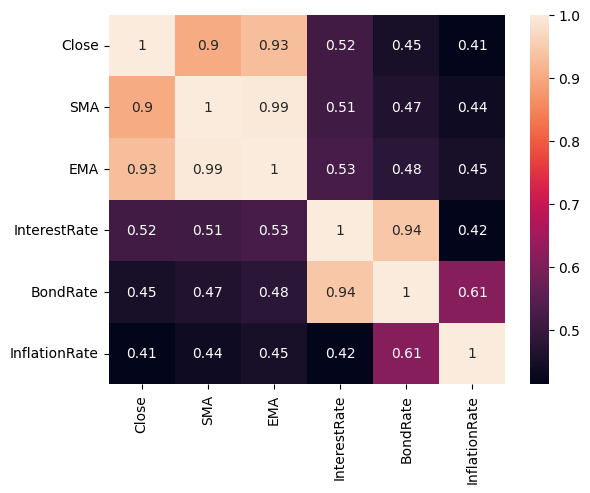

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame
dataset_knn_pd = dataset_knn.toPandas()

# Exclude non-numeric columns for correlation computation
numeric_dataset = dataset_knn_pd.select_dtypes(include=[float, int])

# Compute the correlation matrix
corr = numeric_dataset.corr()

# Generate a heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.show()


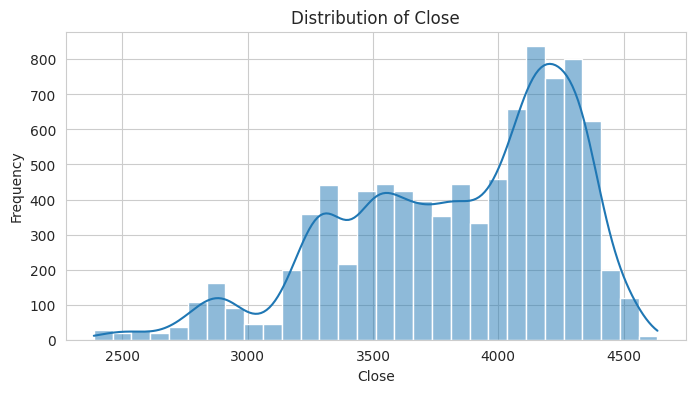

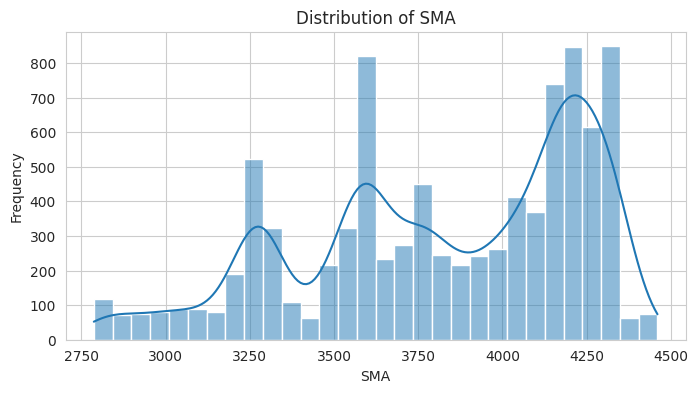

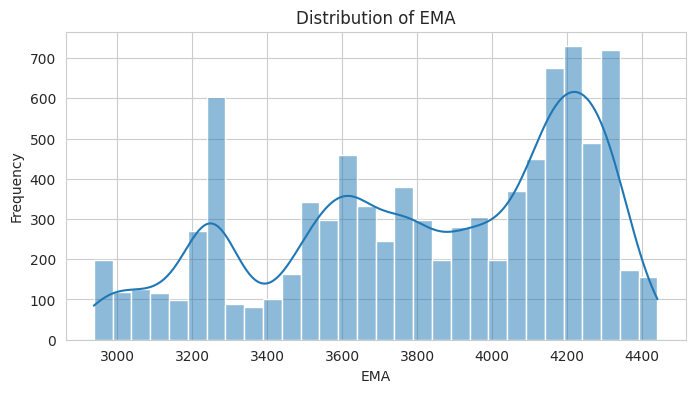

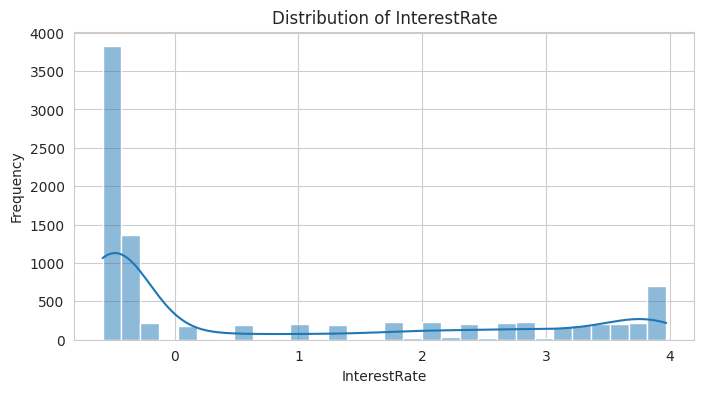

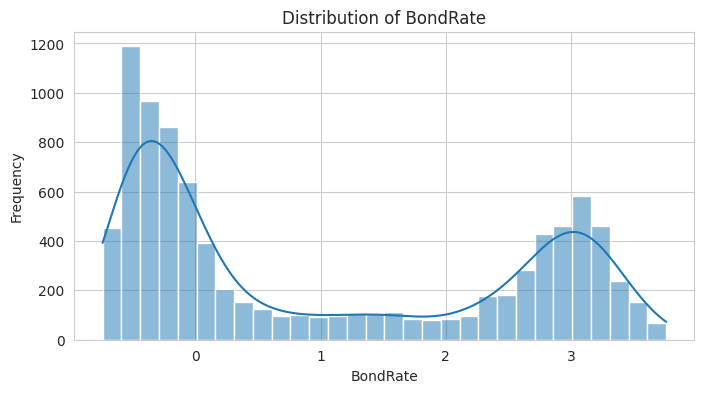

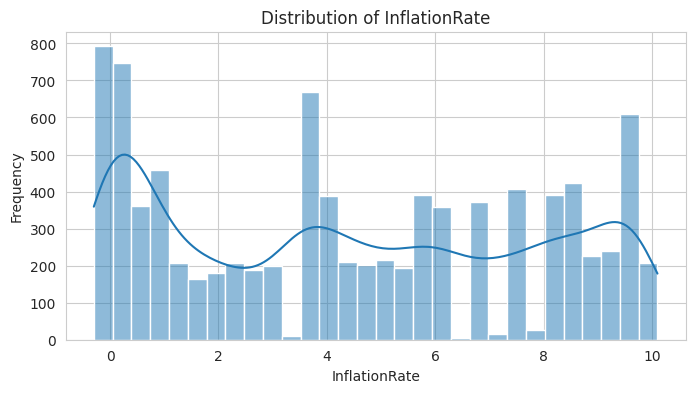

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# List of key metrics to analyze
metrics = ['Close', 'SMA', 'EMA', 'InterestRate', 'BondRate', 'InflationRate']

# Plotting the distribution for each metric
for metric in metrics:
    plt.figure(figsize=(8, 4))
    sns.histplot(dataset_knn_pd[metric], kde=True, bins=30)
    plt.title(f'Distribution of {metric}')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.show()


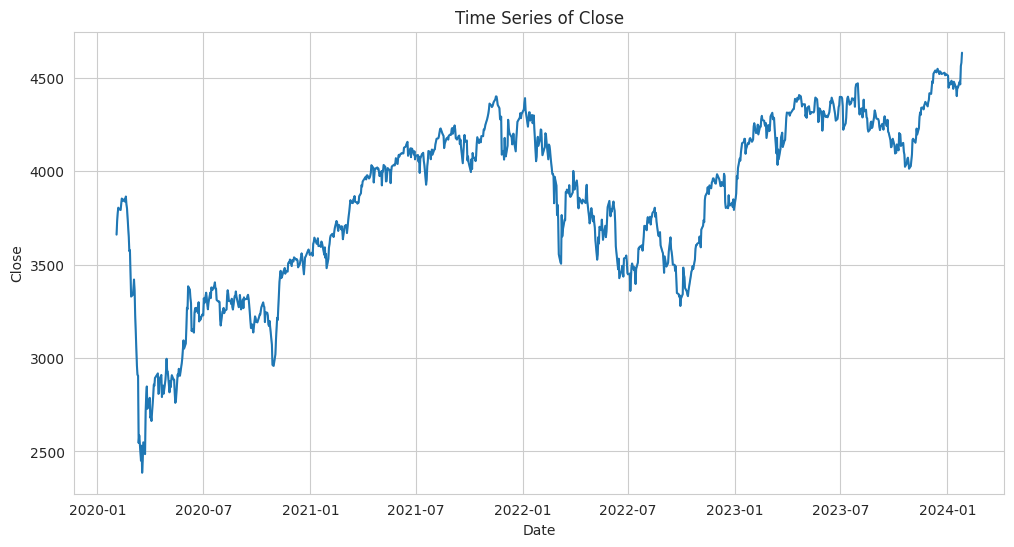

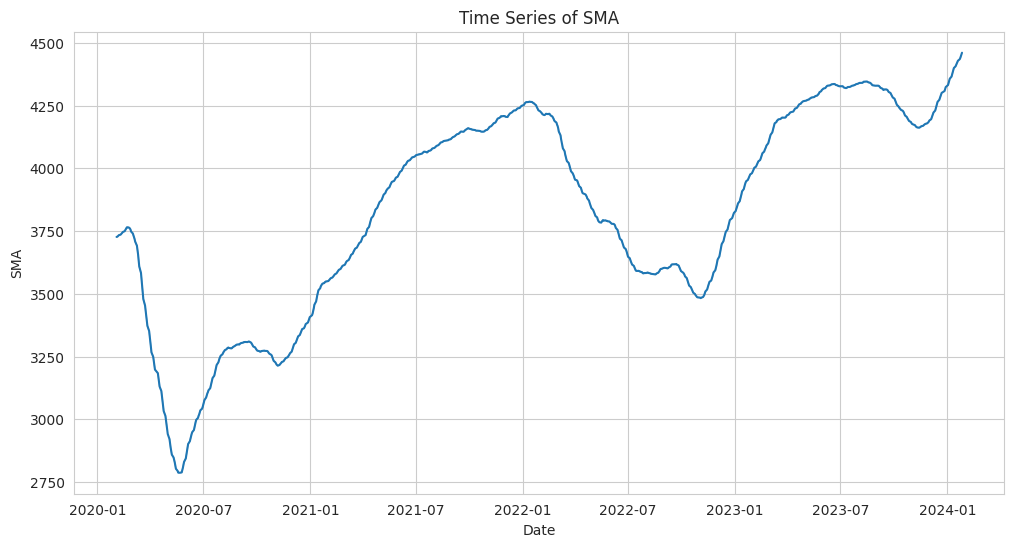

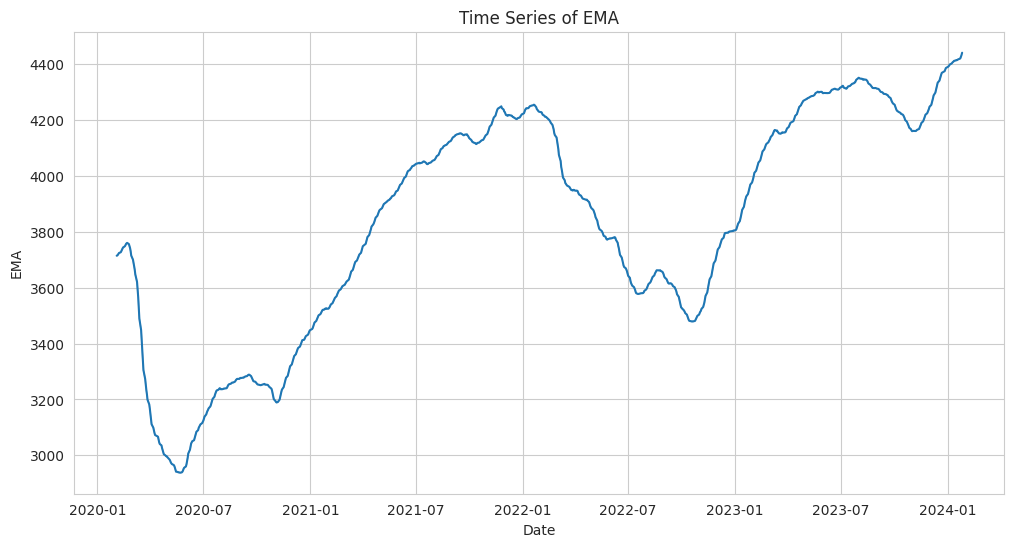

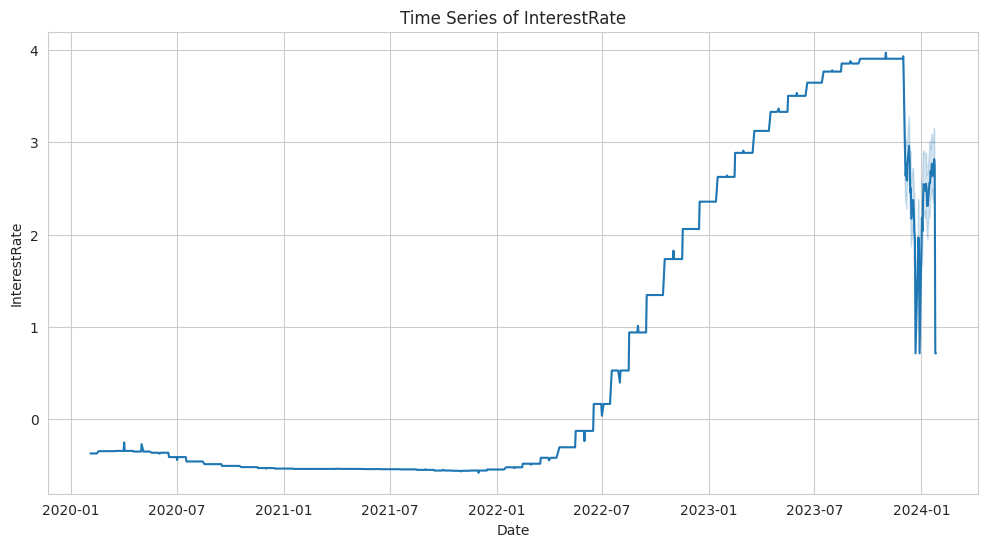

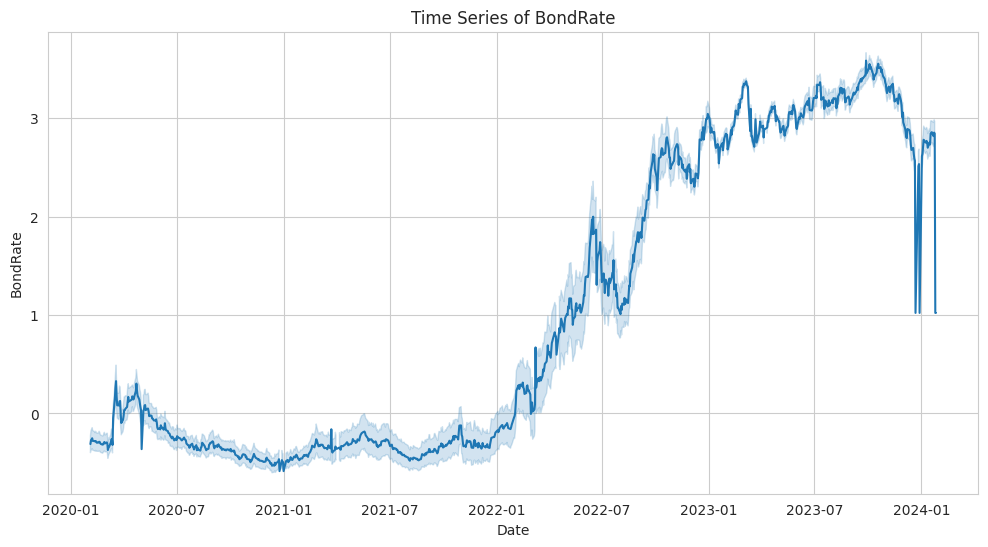

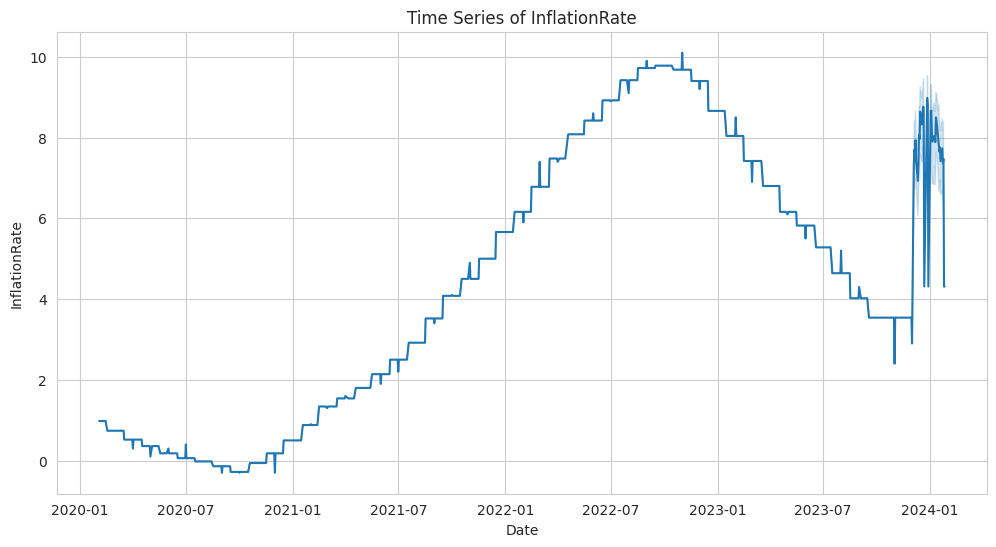

In [36]:
# Plotting time series for each metric
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Date', y=metric, data=dataset_knn_pd)
    plt.title(f'Time Series of {metric}')
    plt.xlabel('Date')
    plt.ylabel(metric)
    plt.show()


In [37]:
# Convert Spark DataFrame to Pandas DataFrame
dataset_knn_pd = dataset_knn.toPandas()

# Ensure the 'Date' column is in datetime format and set as the index
dataset_knn_pd['Date'] = pd.to_datetime(dataset_knn_pd['Date'])
dataset_knn_pd.set_index('Date', inplace=True)

# Filter for the most recent year
max_date = dataset_knn_pd.index.max()
one_year_ago = max_date - pd.DateOffset(years=1)
recent_year_data = dataset_knn_pd[dataset_knn_pd.index >= one_year_ago]

# Select the 'Close' column for analysis
close_series_recent = recent_year_data['Close']

# Perform seasonal decomposition
result = seasonal_decompose(close_series_recent, model='additive', period=365)

# Plot the decomposed components
result.plot()
plt.show()

NameError: name 'seasonal_decompose' is not defined

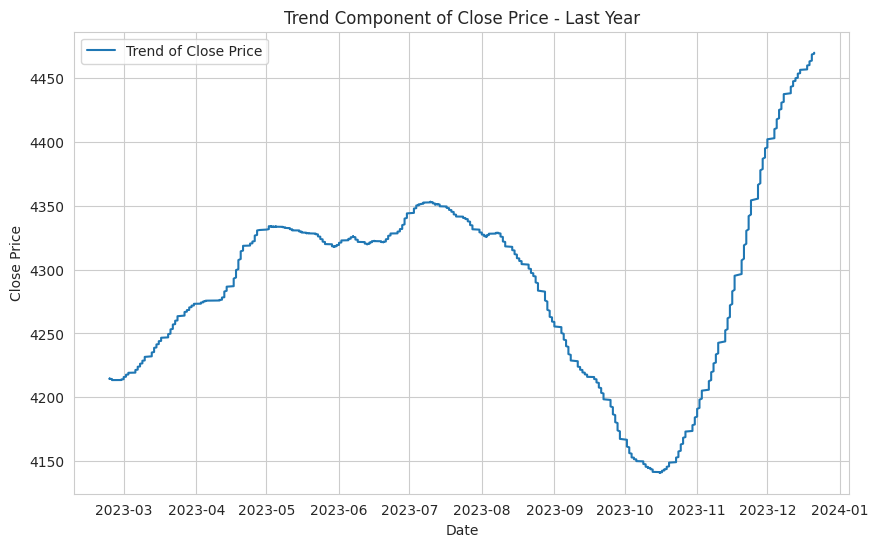

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert Spark DataFrame to Pandas DataFrame
dataset_knn_pd = dataset_knn.toPandas()

# Make sure the 'Date' column is in datetime format and set as the index
dataset_knn_pd['Date'] = pd.to_datetime(dataset_knn_pd['Date'])
dataset_knn_pd.set_index('Date', inplace=True)

# Filter for the most recent year
max_date = dataset_knn_pd.index.max()
one_year_ago = max_date - pd.DateOffset(years=1)
recent_year_data = dataset_knn_pd[dataset_knn_pd.index >= one_year_ago]

# Select the 'Close' column
close_series_recent = recent_year_data['Close']

# Decompose to extract the trend component
decomposition = seasonal_decompose(close_series_recent, model='additive', period=365)
trend = decomposition.trend

# Plotting the trend
plt.figure(figsize=(10, 6))
plt.plot(trend, label='Trend of Close Price')
plt.title('Trend Component of Close Price - Last Year')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

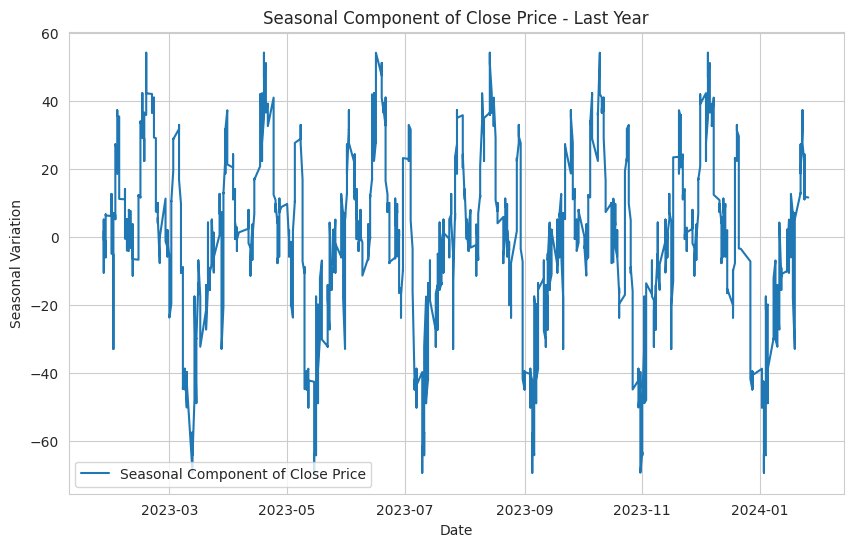

In [39]:
# Plotting the seasonal component
seasonal_component = decomposition.seasonal

plt.figure(figsize=(10, 6))
plt.plot(seasonal_component, label='Seasonal Component of Close Price')
plt.title('Seasonal Component of Close Price - Last Year')
plt.xlabel('Date')
plt.ylabel('Seasonal Variation')
plt.legend()
plt.show()

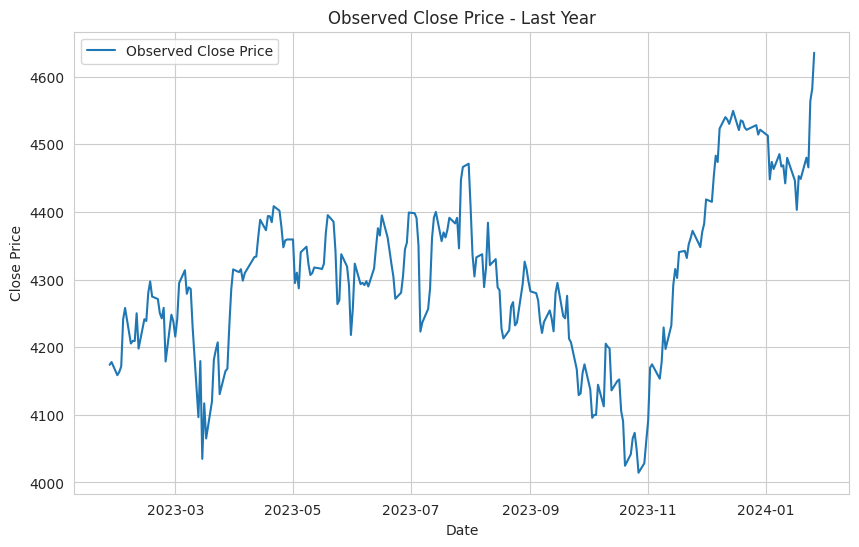

In [40]:
# Plotting the observed data
observed_component = decomposition.observed

plt.figure(figsize=(10, 6))
plt.plot(observed_component, label='Observed Close Price')
plt.title('Observed Close Price - Last Year')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

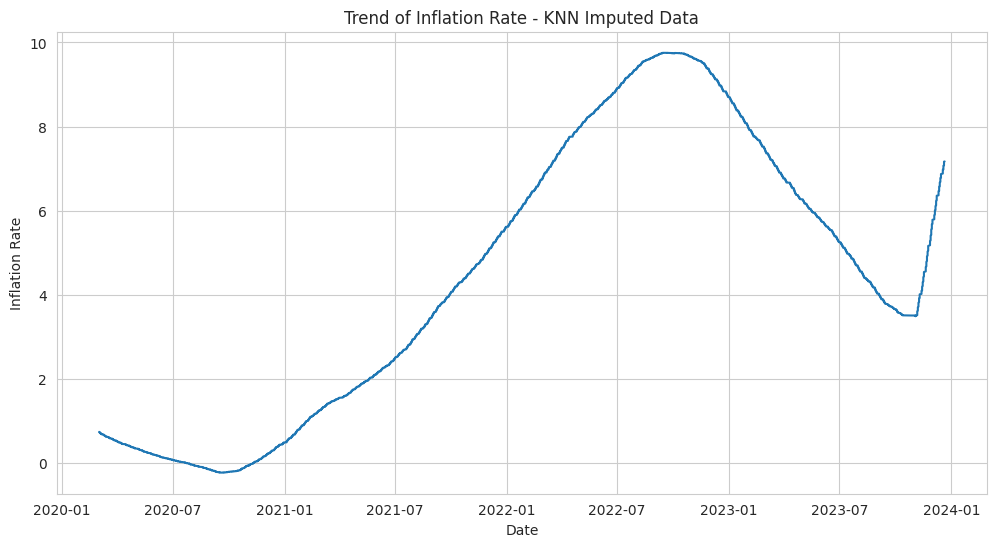

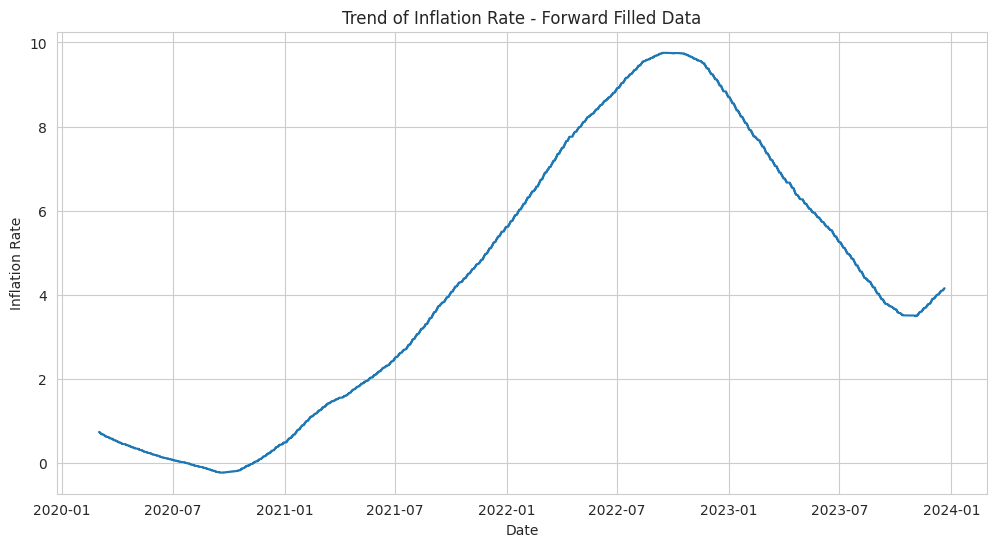

In [41]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

# Function to create a trend plot for Inflation Rate
def create_trend_plot(dataframe, title):
    # Ensure 'Date' is the index and is in datetime format
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe.set_index('Date', inplace=True)

    # Decompose to extract the trend component
    result = seasonal_decompose(dataframe['InflationRate'], model='additive', period=365)
    
    # Plotting the trend component
    plt.figure(figsize=(12, 6))
    plt.plot(result.trend)
    plt.title(f'Trend of Inflation Rate - {title}')
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate')
    plt.show()

# Convert Spark DataFrame to Pandas DataFrame if not already done
dataset_knn_pd = dataset_knn.toPandas()
dataset_ff_pd = dataset_ff.toPandas()

# Create trend plots
create_trend_plot(dataset_knn_pd, "KNN Imputed Data")
create_trend_plot(dataset_ff_pd, "Forward Filled Data")

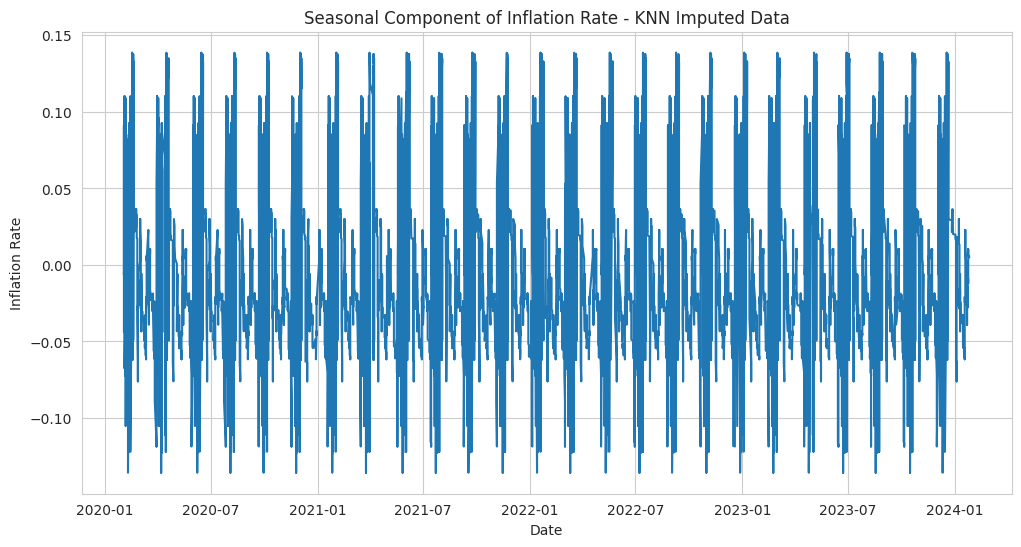

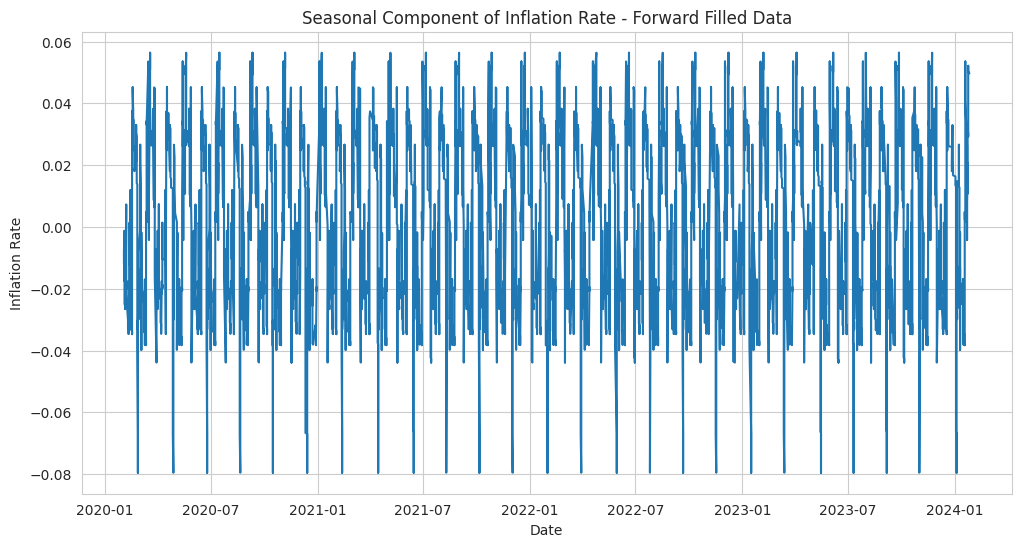

In [42]:
def create_seasonal_plot(dataframe, title):
    # Check if 'Date' column exists, and if so, convert it to datetime and set as index
    if 'Date' in dataframe.columns:
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        dataframe.set_index('Date', inplace=True)

    # Decompose to extract the seasonal component
    result = seasonal_decompose(dataframe['InflationRate'], model='additive', period=365)
    
    # Plotting the seasonal component
    plt.figure(figsize=(12, 6))
    plt.plot(result.seasonal)
    plt.title(f'Seasonal Component of Inflation Rate - {title}')
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate')
    plt.show()

# Create seasonal plots
create_seasonal_plot(dataset_knn_pd, "KNN Imputed Data")
create_seasonal_plot(dataset_ff_pd, "Forward Filled Data")

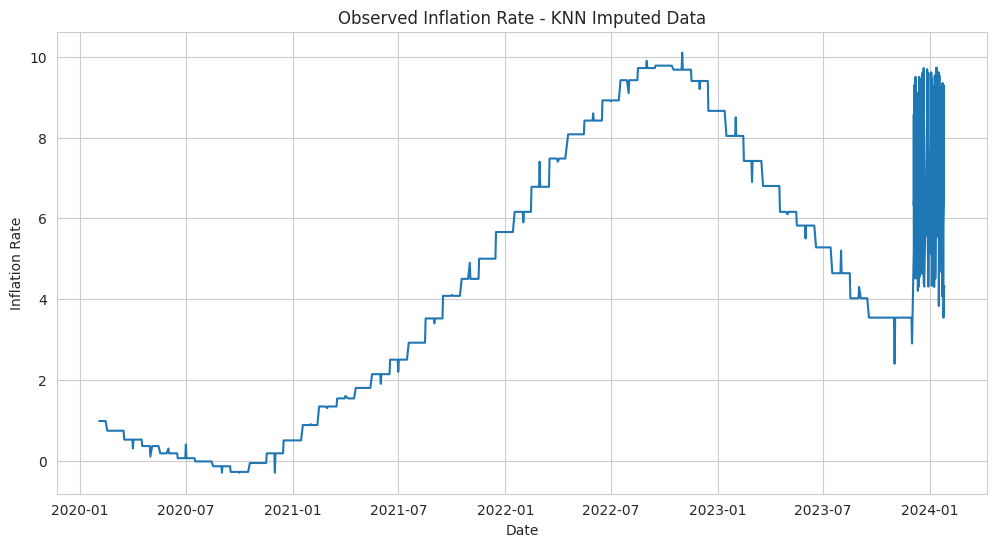

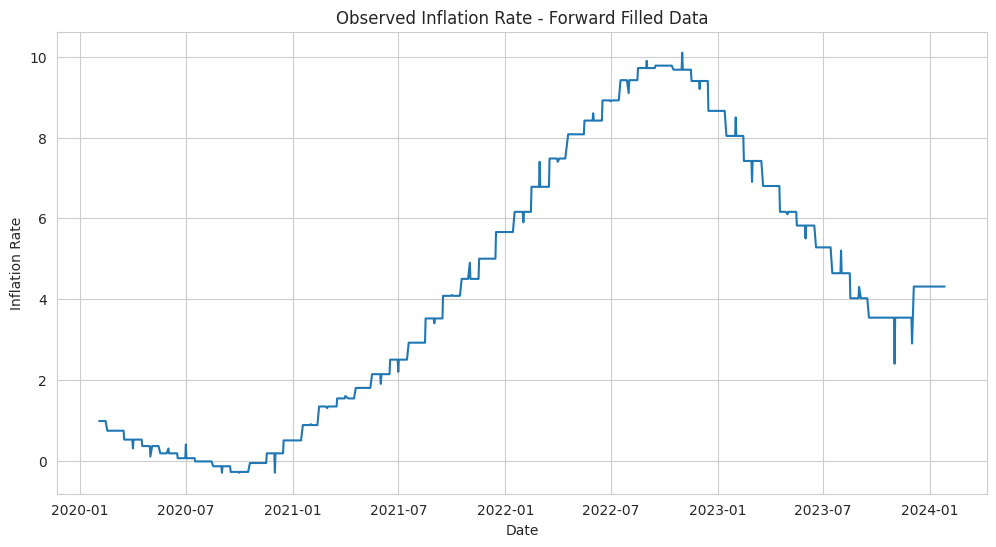

In [43]:
def create_observed_plot(dataframe, title):
    # Check if 'Date' column exists, and if so, convert it to datetime and set as index
    if 'Date' in dataframe.columns:
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        dataframe.set_index('Date', inplace=True)

    # Decompose to extract the observed component
    result = seasonal_decompose(dataframe['InflationRate'], model='additive', period=365)
    
    # Plotting the observed component
    plt.figure(figsize=(12, 6))
    plt.plot(result.observed)
    plt.title(f'Observed Inflation Rate - {title}')
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate')
    plt.show()

# Create observed plots
create_observed_plot(dataset_knn_pd, "KNN Imputed Data")
create_observed_plot(dataset_ff_pd, "Forward Filled Data")


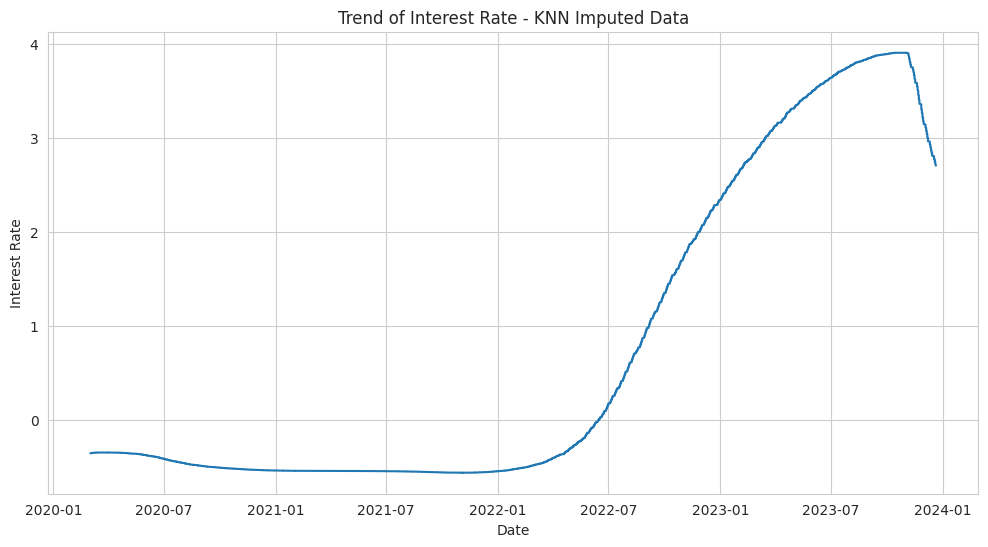

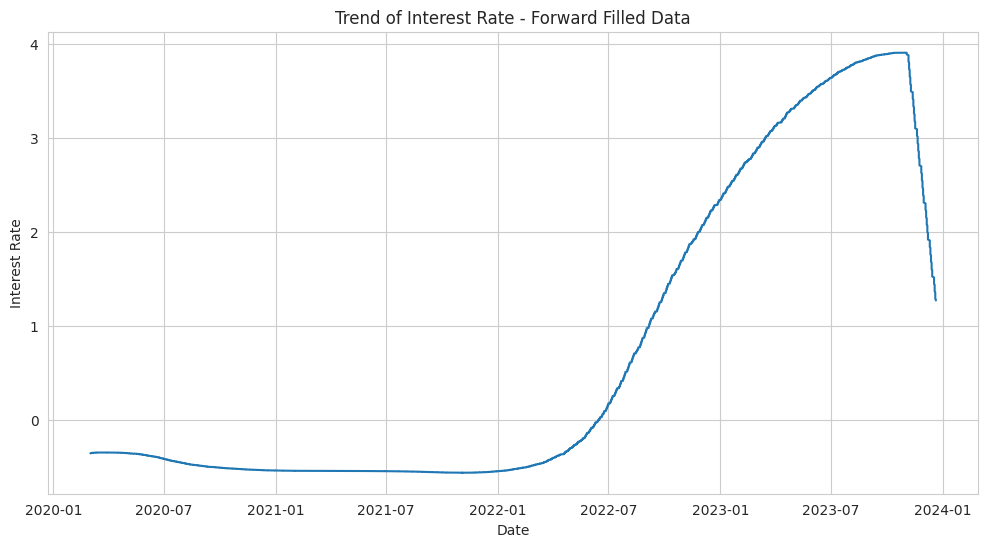

In [44]:
def create_trend_plot_interest(dataframe, title):
    if 'Date' in dataframe.columns:
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        dataframe.set_index('Date', inplace=True)

    result = seasonal_decompose(dataframe['InterestRate'], model='additive', period=365)
    plt.figure(figsize=(12, 6))
    plt.plot(result.trend)
    plt.title(f'Trend of Interest Rate - {title}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate')
    plt.show()

create_trend_plot_interest(dataset_knn_pd, "KNN Imputed Data")
create_trend_plot_interest(dataset_ff_pd, "Forward Filled Data")

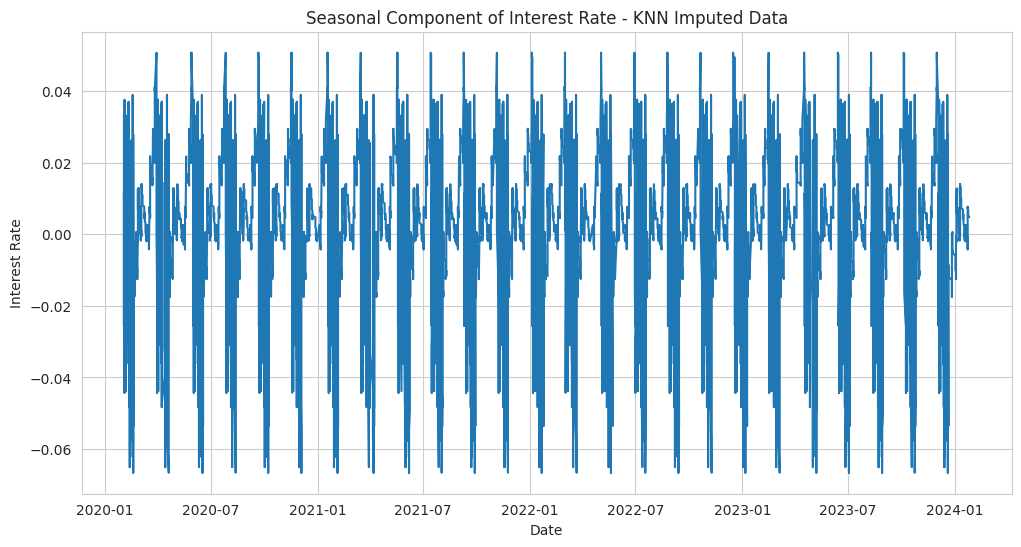

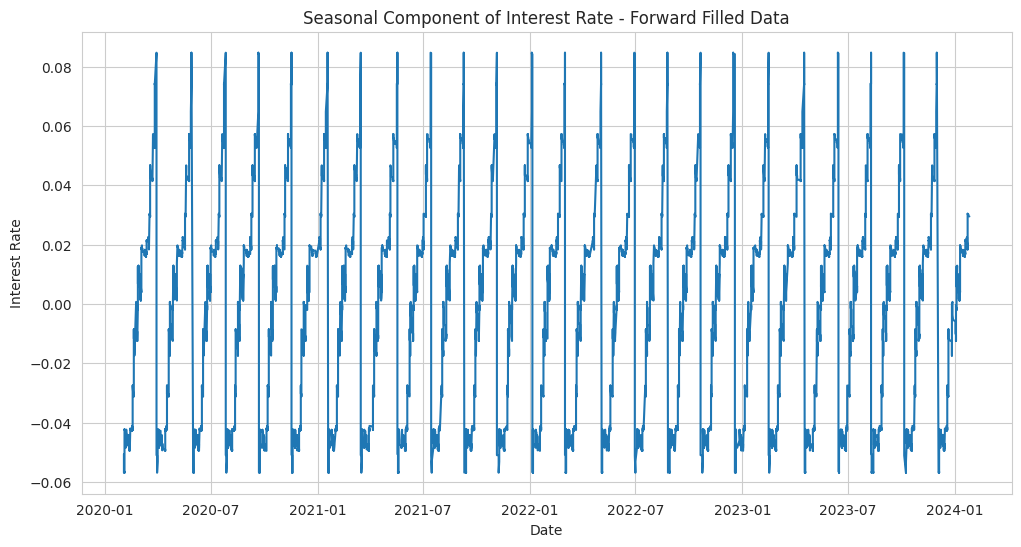

In [45]:
def create_seasonal_plot_interest(dataframe, title):
    if 'Date' in dataframe.columns:
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        dataframe.set_index('Date', inplace=True)

    result = seasonal_decompose(dataframe['InterestRate'], model='additive', period=365)
    plt.figure(figsize=(12, 6))
    plt.plot(result.seasonal)
    plt.title(f'Seasonal Component of Interest Rate - {title}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate')
    plt.show()

create_seasonal_plot_interest(dataset_knn_pd, "KNN Imputed Data")
create_seasonal_plot_interest(dataset_ff_pd, "Forward Filled Data")


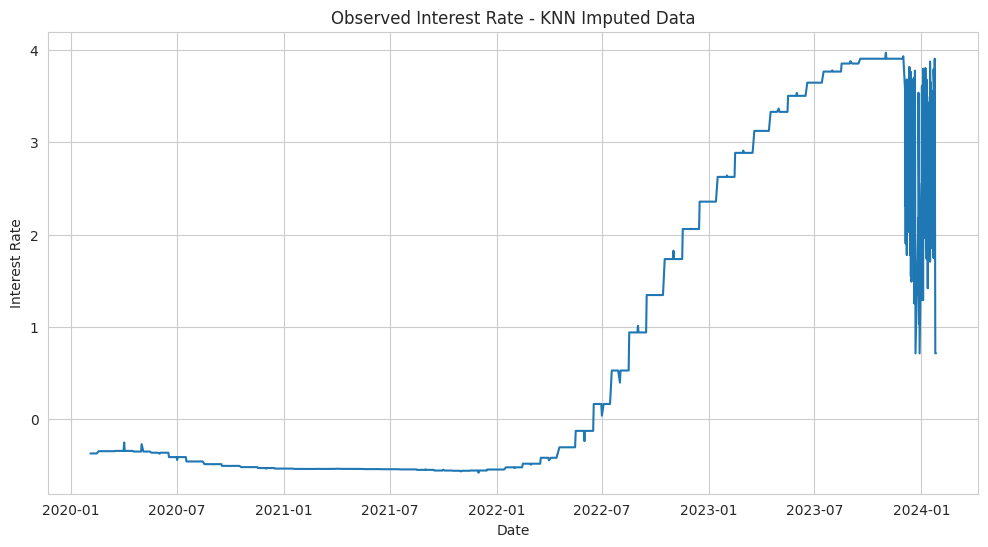

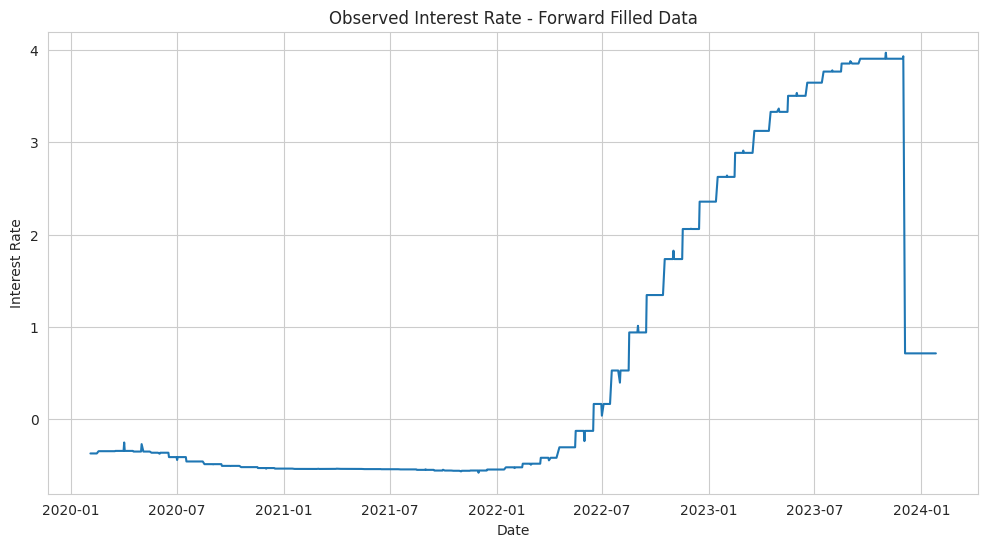

In [46]:
def create_observed_plot_interest(dataframe, title):
    if 'Date' in dataframe.columns:
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        dataframe.set_index('Date', inplace=True)

    result = seasonal_decompose(dataframe['InterestRate'], model='additive', period=365)
    plt.figure(figsize=(12, 6))
    plt.plot(result.observed)
    plt.title(f'Observed Interest Rate - {title}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate')
    plt.show()

create_observed_plot_interest(dataset_knn_pd, "KNN Imputed Data")
create_observed_plot_interest(dataset_ff_pd, "Forward Filled Data")
